<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 7
# Student 1: Ambarish Moharil
# Student 2: Kunal Geed
# Student 3: Mert Lostar

In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
#%matplotlib inline
%pylab inline
# torch.set_grad_enabled(True)  # Context-manager 


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [3]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


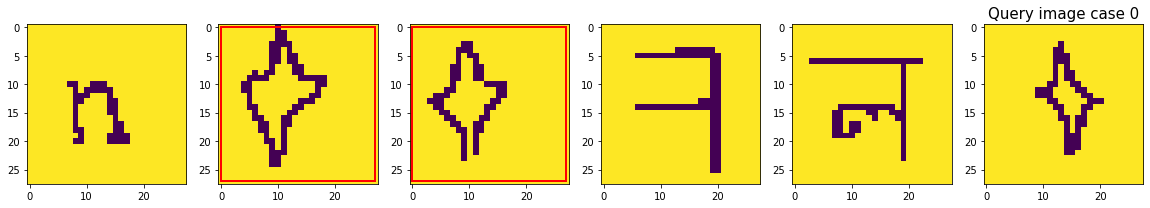

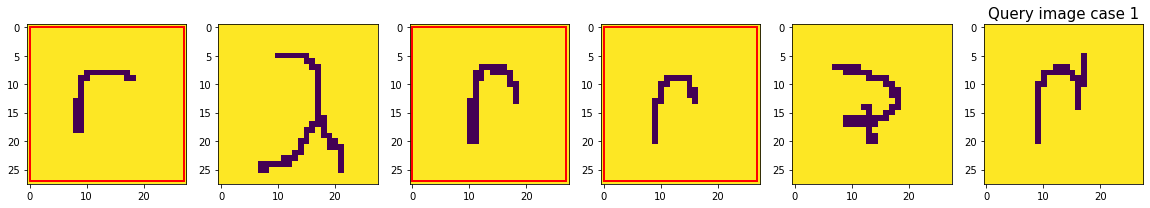

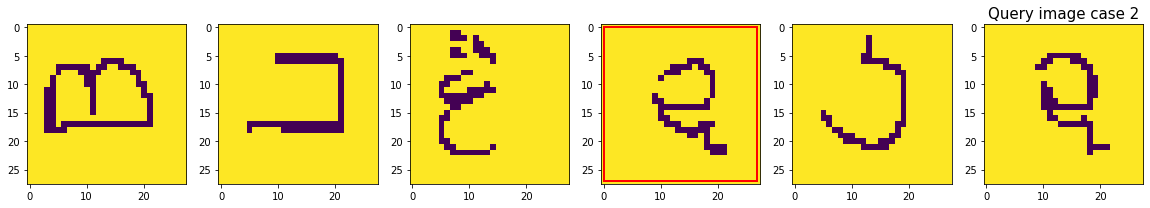

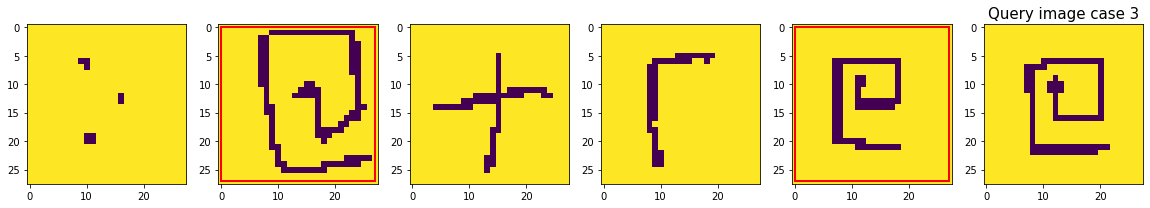

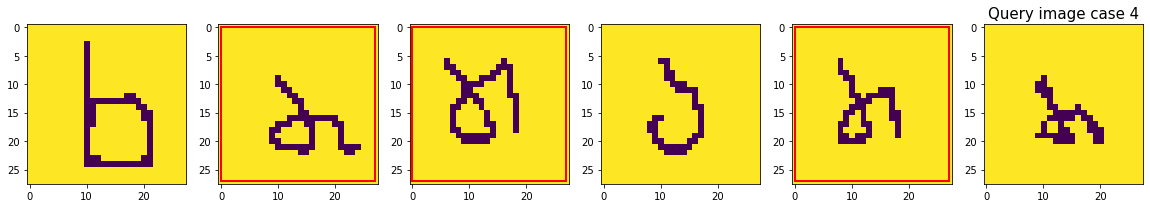

In [4]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [5]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



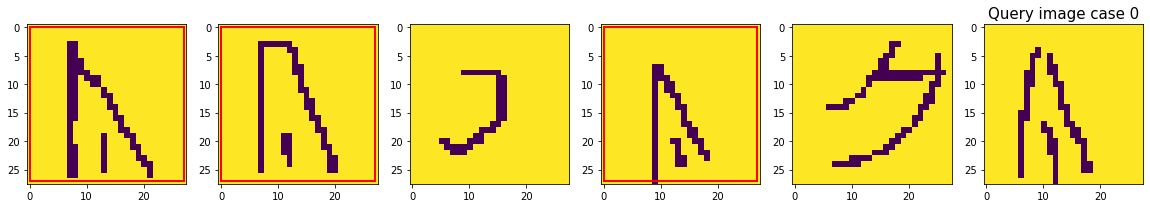

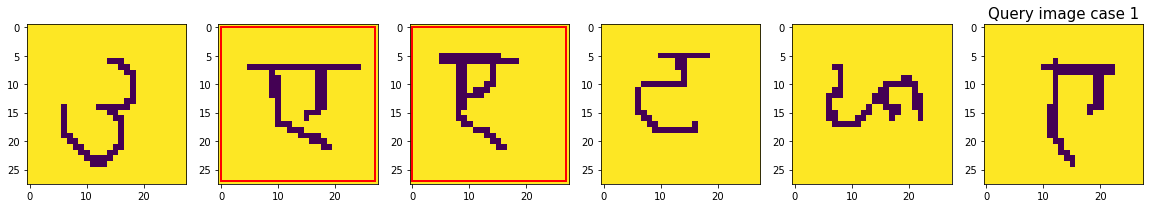

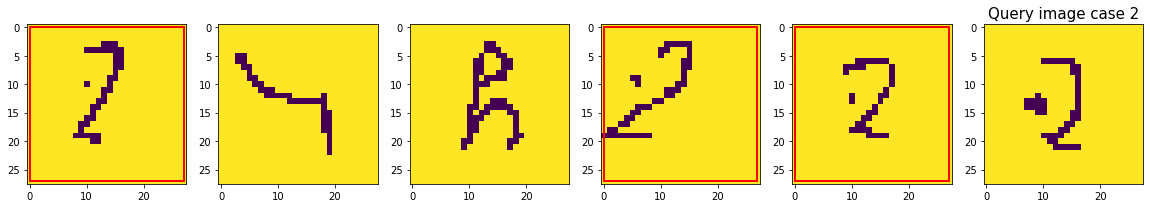

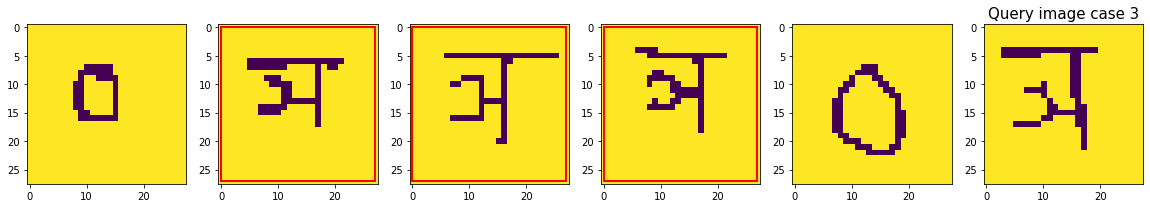

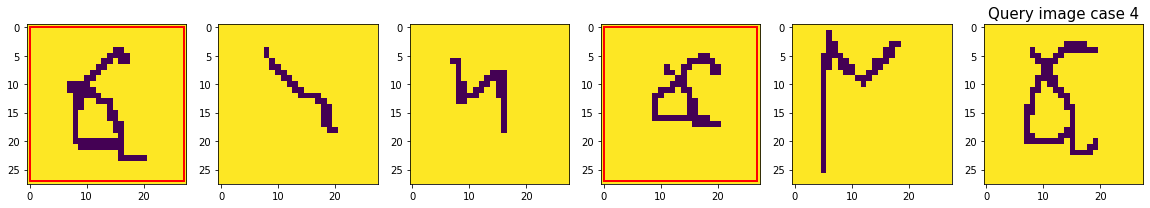

In [6]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [10]:
#Affine Transformations - Data Augmentation
from PIL import Image
import torchvision.transforms as T

def sample_and_transform(train_data,labels,sample_rate=0.5): 
  idxs = np.random.randint(0,len(train_data),int(len(train_data)*sample_rate))
  affine_transformer = T.RandomAffine(degrees=0,translate=(0.1,0.1),scale = (1,1.1),fill=1)
  new_samples = []
  new_samples_lbls = []
  for idx in idxs:
    sample = train_data[idx,:]
    new_sample = []
    new_sample_lbls = []
    for id,img in enumerate(sample):
      im = Image.fromarray(img)
      im = affine_transformer.forward(im)
      new_sample.append(np.asarray(im))
      if id < 5:
        new_sample_lbls.append(labels[idx,id])
    new_samples.append(new_sample)
    new_samples_lbls.append(new_sample_lbls)
  new_samples = np.array(new_samples)
  new_samples_lbls = np.array(new_samples_lbls)
  return np.concatenate((train_data,new_samples)),np.concatenate((labels,new_samples_lbls))
    
#train_data,train_label = sample_and_transform(train_data,train_label,0.5)

In [11]:
## Build Sample Selector ##
from torch.utils.data import random_split


from sklearn.model_selection import train_test_split

train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.2, random_state=69)

train_data , train_label = sample_and_transform(train_data, train_label, sample_rate = 0.5)

train_dataset=MyDataset(train_data,train_label)
val_dataset = MyDataset(val_data,val_label)
test_dataset=MyDataset(test_data,test_label)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)





In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# N 5-way one shot trials essentially 
    N <= len(test_set)

In [13]:
## Model Definition ##

### CNN Architecture (https://arxiv.org/pdf/1606.04080v2.pdf)

In [14]:
from torch.nn.modules.batchnorm import BatchNorm2d
#ref :- https://github.com/fangpin/siamese-pytorch (Reimplementation of the Omniglot Paper https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

class Siamese_1(nn.Module):

    def __init__(self):
        super(Siamese_1, self).__init__()
        self.conv = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, 3,padding=1),  # 64@28*28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3,padding=1),  # 128@28*28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 128@14*14

            # Block 2
            nn.Conv2d(128, 256, 3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),    # 256@14*14
            nn.Conv2d(256, 384, 3,padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2, stride=2), # 384@7*7

            # Block 3
            nn.Conv2d(384, 512, 3,padding=1),#512@7*7
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),   
            nn.Conv2d(512, 576, 3, padding=1), # 576@7*7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2), # 576@3*3
        )


        self.liner = nn.Sequential(nn.Linear(576*3*3, 640), nn.Sigmoid())
        self.out = nn.Sequential(nn.Linear(640, 1), nn.Sigmoid()) #Use with BCELoss
        #self.out = nn.Linear(1024, 1) #Use with BCEwithLogitLoss
        
    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        return out

In [15]:
## LOSS Definition ##

#Defining a Binary Cross-Entropy Loss (As Similarity is computed using a Sigmoid Function)

class BCELoss(nn.Module):
    
    def __init__(self):
        super(BCELoss, self).__init__()
        
    def forward(self, output, label):
        loss_fn = torch.nn.BCELoss()
        loss = loss_fn(output, label)
        return loss
    


In [16]:
#peek into the model architecture

def model_summary(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\n No of trainable parameters {temp:,} in the model')
    
model_summary(Siamese_1())
#model_summary(Net())

The model architecture:

 Siamese_1(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14

/tmp/ipykernel_71638/3979134909.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [17]:
## Training ##

In [39]:
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))


# def load_checkpoint(model, optimizer, path):
#     save_path = path
#     state_dict = torch.load(save_path, map_location = 'cpu')
#     model.load_state_dict(state_dict['model_state_dict'])
#     optimizer.load_state_dict(state_dict['optimizer_state_dict'])
#     val_loss = state_dict['val_loss']
#     val_acc = state_dict['val_acc']
#     train_acc = state_dict['train_acc']
#     train_loss = state_dict['train_loss']
#     print(f'Model loaded from <== {save_path}')
    
#     return val_loss

In [56]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        tr_acc = []
        tt_acc = []
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, labels in train_loader:
            support_set, queries = np.split(train_data, [5], axis=1)
            labels =  torch.tensor_split(labels, 5, dim=1)
            # Forward
            case_loss = 0.0
            cur_train_acc = 0.0
            cur_val_acc = 0.0
            for x in range(5):
                img1 = queries.to(device)
                x2 = support_set[:,x]
                img2 = x2.view(-1,1,28,28).to(device)
       
                output1 = model.forward(img1, img2)
                  
                #Accuracy over a batch of 10
                curr_train_acc = torch.sum(torch.eq(labels[x].cuda(), torch.round(output1.cuda())))/10 #divide by the len of the batch_size
                #curr_train_acc += curr_train_acc
                tr_acc.append(curr_train_acc)

                #loss_fn = torch.nn.BCELoss()
                loss = criterion(output1, labels[x].float().to(device))
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                case_loss += loss.item()

            case_loss = case_loss/5
            cur_train_acc = torch.mean(torch.stack(tr_acc)) #Divide by the number of images in the support set
   
            #print(cur_train_acc)
            running_loss += case_loss
            #running_train_acc += cur_train_acc
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        #avg_train_acc = running_train_acc/len(train_loader) 

        train_acc.append(cur_train_acc)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        running_val_acc = 0.0 
        with torch.no_grad():
            model.eval()
            for val_data, labels in test_loader:
                support_set, queries = np.split(val_data, [5], axis=1)
                labels =  torch.tensor_split(labels, 5, dim=1)
                case_loss = 0.0
                curr_val_acc = 0.0
                for x in range(5):
                    img1 = queries.to(device)
                    #img2 = support_set.to(device)
                    x2 = support_set[:,x]
                    img2 = x2.view(-1,1,28,28).to(device)
                    #labels = labels[:,x].view(-1,1).to(device)
                    output2 = model.forward(img1, img2)

                    # #Accuracy over a batch of 10
                    curr_val_acc = torch.sum(torch.eq(labels[x].cuda(), torch.round(output2.cuda())))/10 #divide by the len of the batch_size
                    # curr_val_acc += curr_val_acc
                    curr_val_acc = curr_val_acc.float()
                    tt_acc.append(curr_val_acc)

                    loss = criterion(output2, labels[x].float().to(device))
                    case_loss += loss.item()

                case_loss = case_loss/5
                cur_val_acc = torch.mean(torch.stack(tt_acc)) 
                #print("cur val_acc {}".format(cur_val_acc)) #divide by the no of images in the support set
                val_running_loss += case_loss
                #running_val_acc += cur_val_acc
                #print("running_val_acc {}".format(running_val_acc))

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc.append(cur_val_acc)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}, Train Acc : {:.4f}, Val Acc : {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss, cur_train_acc ,cur_val_acc ))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, cur_val_acc, cur_train_acc, avg_train_loss )
    
    print("Finished Training")  

In [20]:
# actual training
import torch.optim as optim


SiameseNet1 = Siamese_1().cuda()

optimizer = torch.optim.SGD(SiameseNet1.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10
save_name = f'SiameseNet_Custom_Net_SGD.pt'
criterion = BCELoss()

obtained_train_loss, obtained_val_loss, obtained_train_acc, obtained_val_acc = train(SiameseNet1, 
                                                      train_loader, test_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/10],Train Loss: 0.3997, Valid Loss: 0.24486461, Train Acc : 0.8149, Val Acc : 0.91159999
Model Saved to ==> SiameseNet_Custom_Net_SGD.pt
Starting epoch 2
Train Pass Completed
Epoch [2/10],Train Loss: 0.1894, Valid Loss: 0.15694641, Train Acc : 0.9358, Val Acc : 0.94640005
Model Saved to ==> SiameseNet_Custom_Net_SGD.pt
Starting epoch 3
Train Pass Completed
Epoch [3/10],Train Loss: 0.1100, Valid Loss: 0.13564563, Train Acc : 0.9676, Val Acc : 0.95020014
Model Saved to ==> SiameseNet_Custom_Net_SGD.pt
Starting epoch 4
Train Pass Completed
Epoch [4/10],Train Loss: 0.0592, Valid Loss: 0.13534895, Train Acc : 0.9878, Val Acc : 0.94920009
Model Saved to ==> SiameseNet_Custom_Net_SGD.pt
Starting epoch 5
Train Pass Completed
Epoch [5/10],Train Loss: 0.0276, Valid Loss: 0.14810219, Train Acc : 0.9973, Val Acc : 0.94540006
Starting epoch 6
Train Pass Completed
Epoch [6/10],Train Loss: 0.0126, Valid Loss: 0.15580679, Train Acc : 0.9995, Val Acc : 0.9

In [21]:
## Evaluation ##

In [22]:
def convert_list_of_tensors(list_input):
  converted_tensor_list = []
  for tensor in list_input:
    converted_tensor_list.append(tensor.to('cpu'))
  return converted_tensor_list

obtained_train_acc = convert_list_of_tensors(obtained_train_acc)
obtained_val_acc = convert_list_of_tensors(obtained_val_acc)

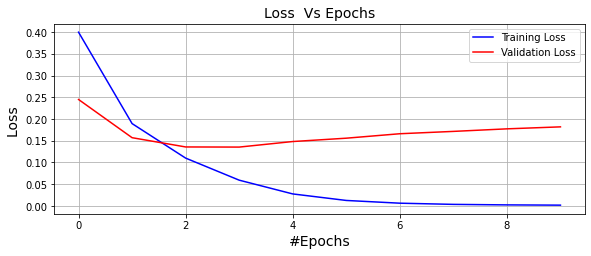

######################################################################


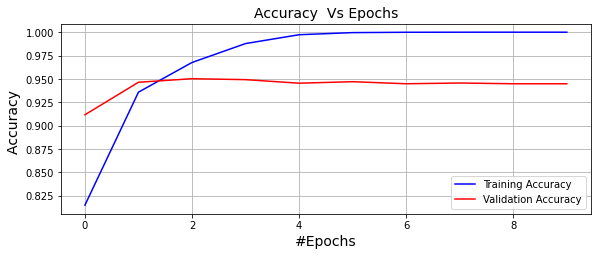

In [24]:
fig = plt.gcf()
fig.set_size_inches(9.5, 3.5)
plt.plot(range(0,10),obtained_train_loss, label = "Training Loss", color = "blue")
plt.plot(range(0,10),obtained_val_loss, label = "Validation Loss", color = "red")
plt.title('Loss  Vs Epochs', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Loss ', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Loss.png')
fig = plt.gcf()
print("######################################################################")
fig.set_size_inches(9.5, 3.5)
plt.plot(range(0,10),obtained_train_acc, label = "Training Accuracy", color = "blue")
plt.plot(range(0,10),obtained_val_acc, label = "Validation Accuracy", color = "red")
plt.title('Accuracy  Vs Epochs', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Accuracy ', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('Accuracy.png')

In [ ]:
#Plot the query_image - support set images and the computed similarity between the tw0. (Do this for a batch)

In [74]:
#Evaluating on the validation set

def evaluate(model, val_loader):
    val_pred_acc = []
    cnt = 0
    outer_pred_list = []
    final_list = []
    with torch.no_grad():
            model.eval()
            for val_data, labels in val_loader:
                support_set, queries = np.split(val_data, [5], axis=1)
                labels =  torch.tensor_split(labels, 5, dim=1)
                case_loss = 0.0
                curr_val_acc = 0.0
                for x in range(5):
                    img1 = queries.to(device)
                    x2 = support_set[:,x]
                    img2 = x2.view(-1,1,28,28).to(device)
                    output2 = model.forward(img1, img2)
                    
                    
                    inner_pred_list = [torch.round(j).item() for j in output2]
                    outer_pred_list.append(inner_pred_list)


                    # #Accuracy over a batch of 10
                    curr_val_acc = torch.sum(torch.eq(labels[x], torch.round(output2)))/10 #divide by the len of the batch_size
                    curr_val_acc = curr_val_acc.float()
                    val_pred_acc .append(curr_val_acc)

                cur_val_acc = torch.mean(torch.stack(val_pred_acc )) 
                cnt +=1

                print("Validation Accuracy for Query Image Batch {} is {}".format(cnt, cur_val_acc))
            return outer_pred_list

In [75]:
#Model Evaluation
import torch
model = Siamese_1()
checkpoint = torch.load('SiameseNet_Custom_Net_SGD_ep3.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

preds = evaluate(model, val_loader)

Validation Accuracy for Query Image Batch 1 is 0.9600000381469727
Validation Accuracy for Query Image Batch 2 is 0.9699999690055847
Validation Accuracy for Query Image Batch 3 is 0.9533332586288452
Validation Accuracy for Query Image Batch 4 is 0.9599999189376831
Validation Accuracy for Query Image Batch 5 is 0.9679999351501465
Validation Accuracy for Query Image Batch 6 is 0.9699999690055847
Validation Accuracy for Query Image Batch 7 is 0.9657142758369446
Validation Accuracy for Query Image Batch 8 is 0.9600000381469727
Validation Accuracy for Query Image Batch 9 is 0.9600000977516174
Validation Accuracy for Query Image Batch 10 is 0.9619999527931213
Validation Accuracy for Query Image Batch 11 is 0.9599999785423279
Validation Accuracy for Query Image Batch 12 is 0.9583333134651184
Validation Accuracy for Query Image Batch 13 is 0.9615384340286255
Validation Accuracy for Query Image Batch 14 is 0.9514286518096924
Validation Accuracy for Query Image Batch 15 is 0.9506667256355286
Vali

Validation Accuracy for Query Image Batch 124 is 0.948225736618042
Validation Accuracy for Query Image Batch 125 is 0.9483199119567871
Validation Accuracy for Query Image Batch 126 is 0.9479364156723022
Validation Accuracy for Query Image Batch 127 is 0.948188841342926
Validation Accuracy for Query Image Batch 128 is 0.948437511920929
Validation Accuracy for Query Image Batch 129 is 0.948062002658844
Validation Accuracy for Query Image Batch 130 is 0.9481538534164429
Validation Accuracy for Query Image Batch 131 is 0.9476335048675537
Validation Accuracy for Query Image Batch 132 is 0.9475756883621216
Validation Accuracy for Query Image Batch 133 is 0.9475186467170715
Validation Accuracy for Query Image Batch 134 is 0.9471640586853027
Validation Accuracy for Query Image Batch 135 is 0.9469628930091858
Validation Accuracy for Query Image Batch 136 is 0.946617603302002
Validation Accuracy for Query Image Batch 137 is 0.946715235710144
Validation Accuracy for Query Image Batch 138 is 0.946

In [121]:
def get_final_preds_in_shape(preds):
    subList = [preds[n:n+5] for n in range(0, len(preds), 5)]

    subArray = np.array(subList).T

    subList_T = []
    for arr in subList:
        arr = np.array(arr).T
        subList_T.append(arr)

    array_preds = []
    for arr1 in subList_T:
        for arr2 in arr:
            array_preds.append(arr2)
    converted_preds = [array.tolist() for array in array_preds] 

    pred_array = np.array(converted_preds)
    #convert 1 to true and 0 to false
    for conv in pred_array:
        for val in conv:
            if val ==1.0:
                val = "True"
            else:
                val = "False"

    predictions = (pred_array > 0).tolist()
    predictions = np.array(predictions)
    
    return predictions

In [123]:
predictions = get_final_preds_in_shape(preds)

In [183]:
print(predictions[7])
print(val_label[7])

[False  True  True  True False]
[False  True False  True False]


/tmp/ipykernel_71638/4235194518.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, 6, figsize=(20,5))


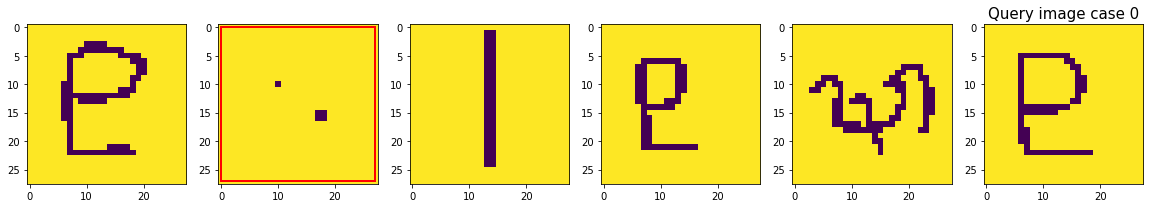

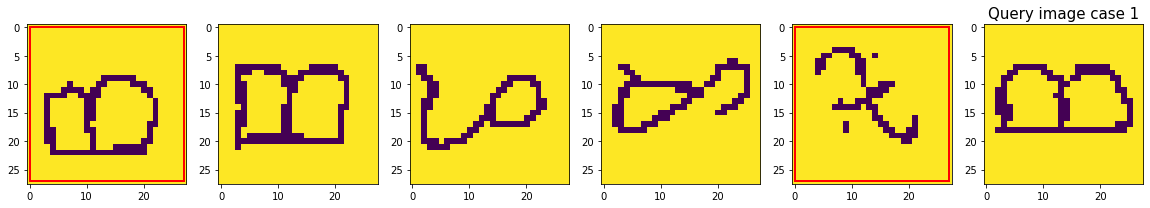

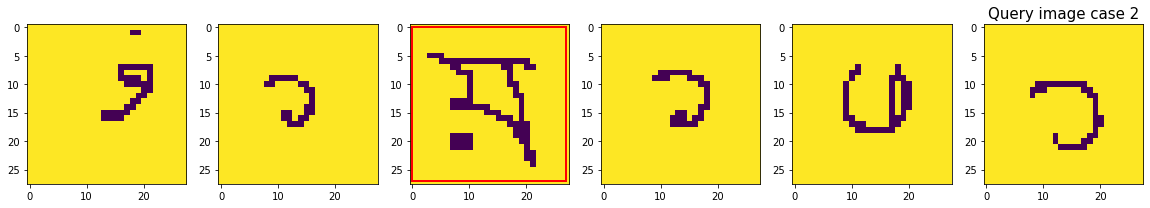

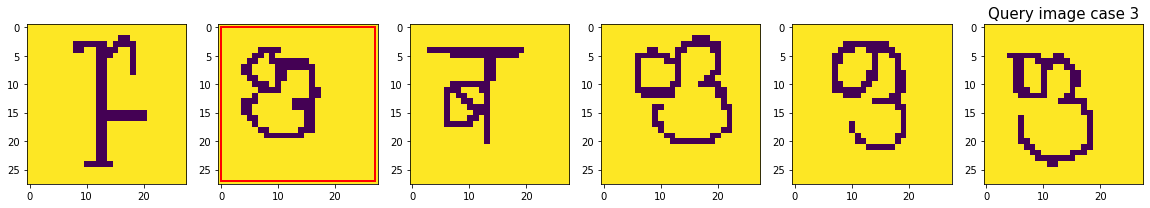

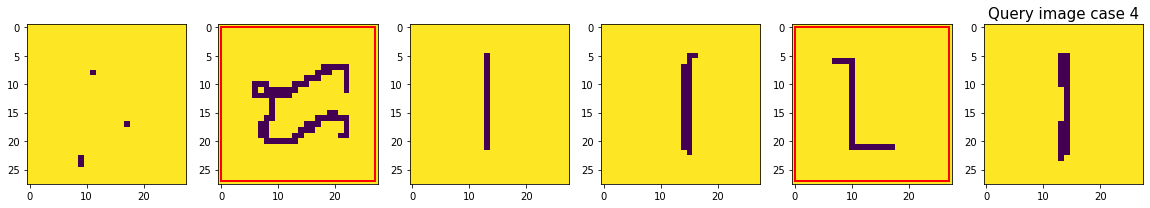

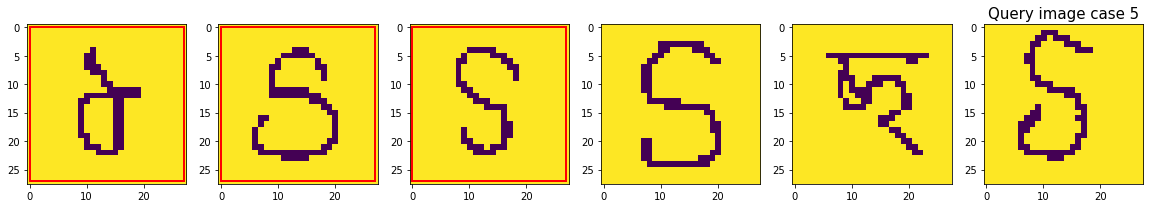

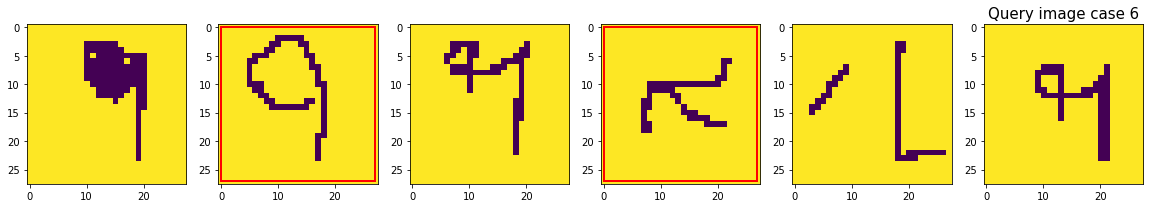

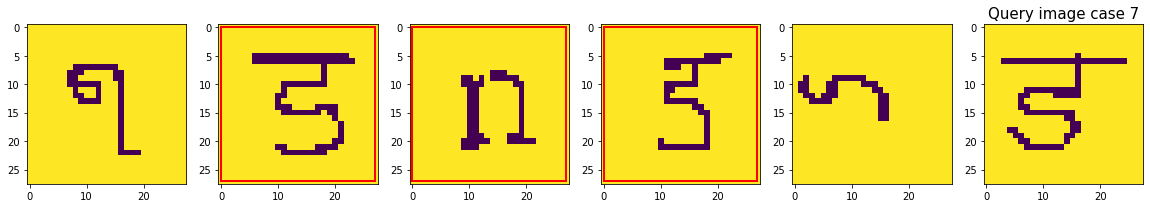

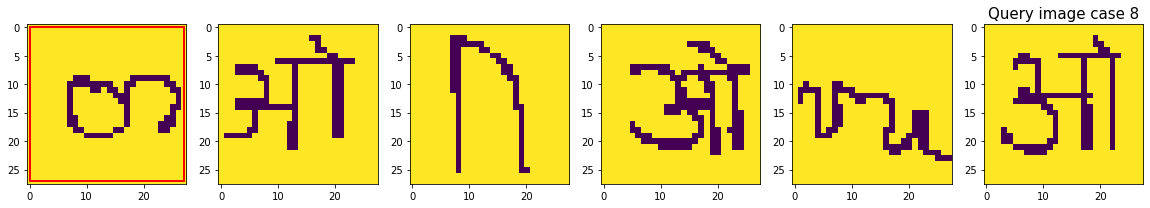

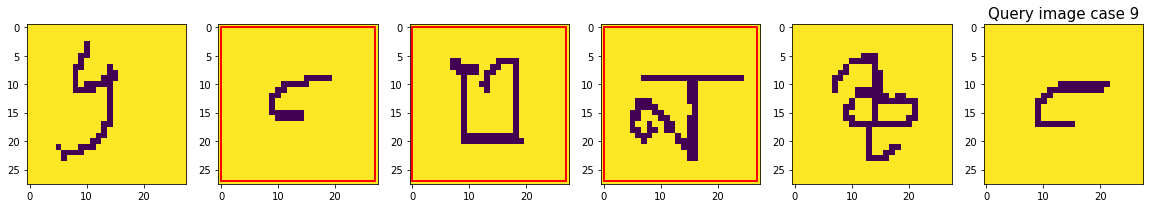

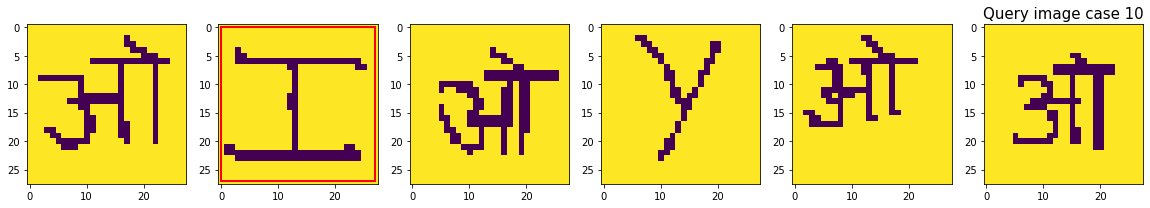

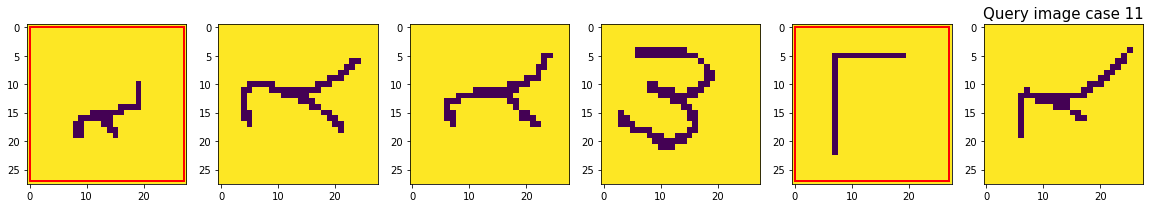

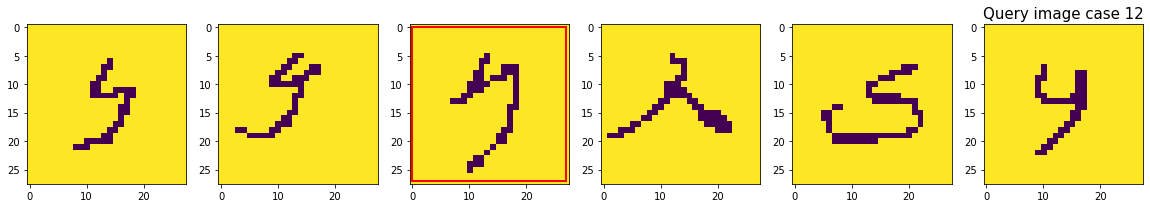

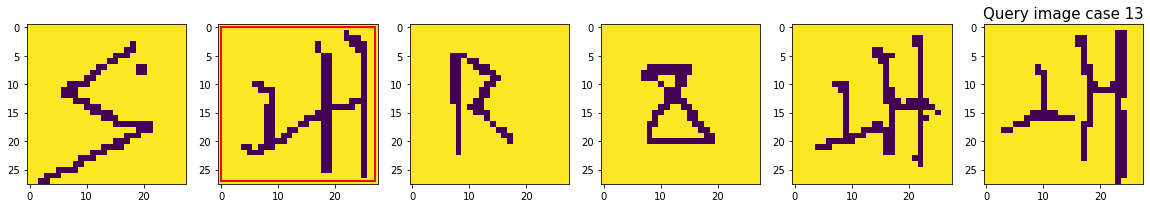

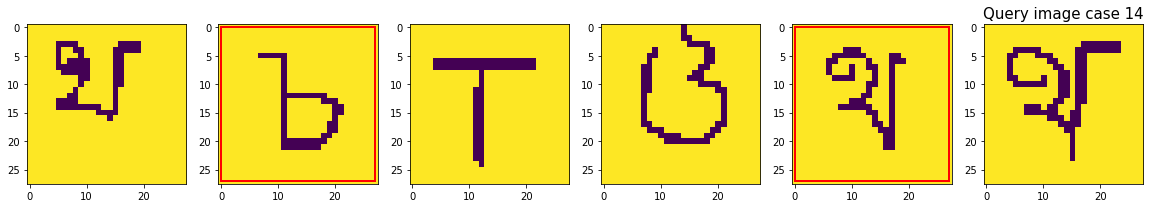

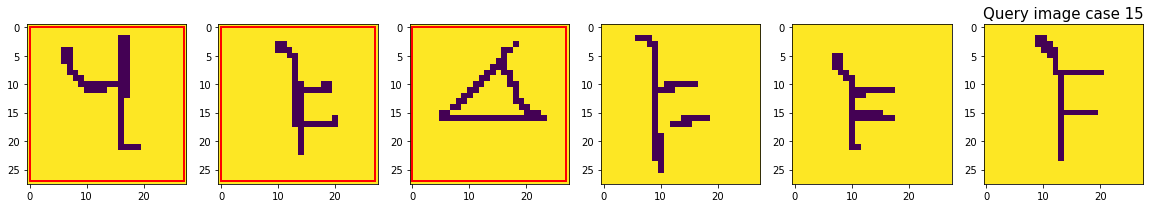

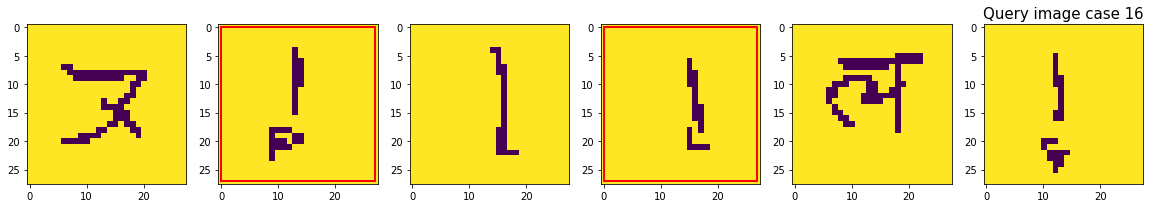

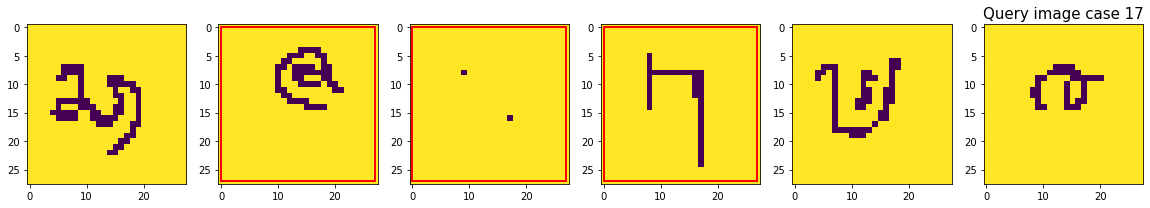

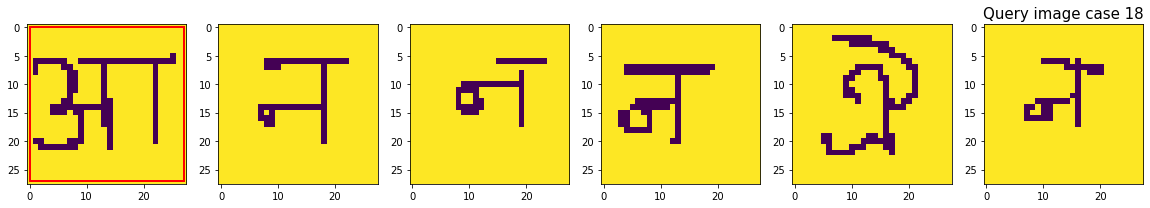

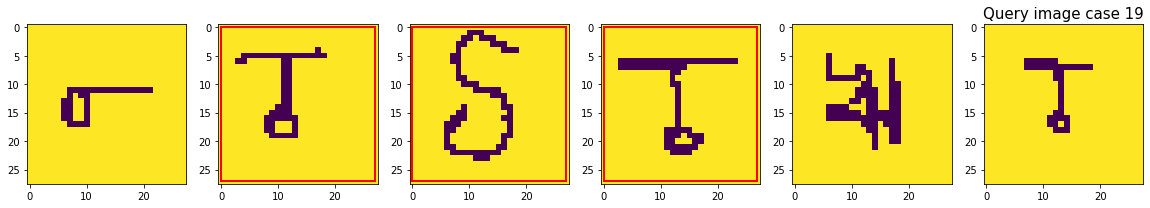

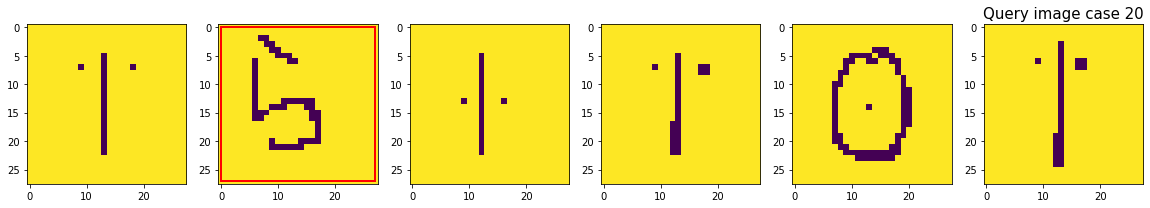

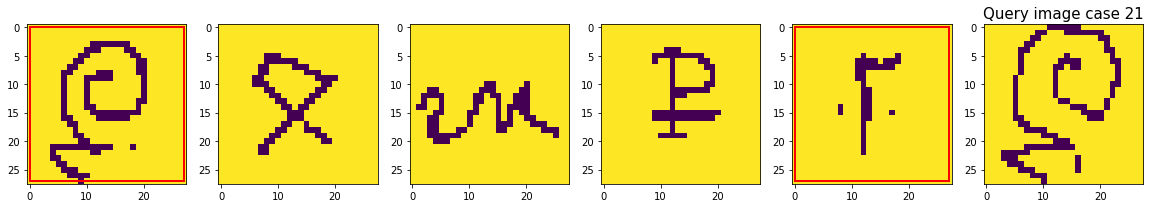

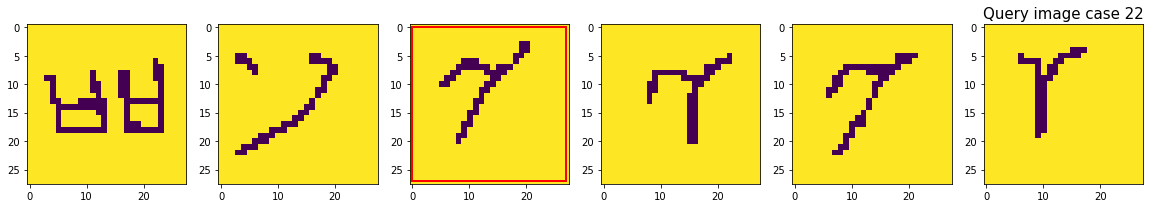

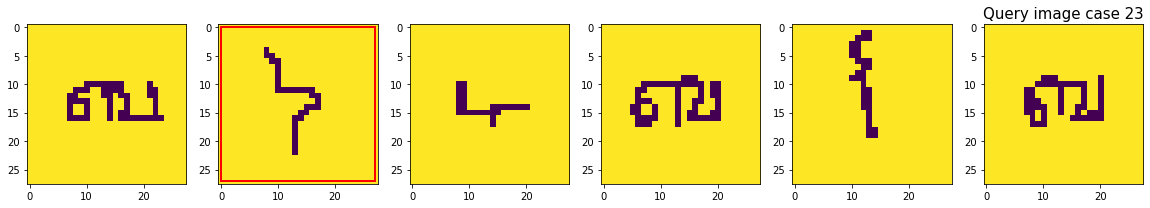

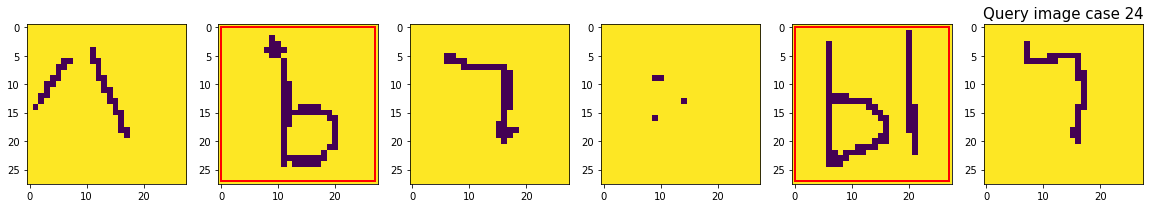

In [129]:
[plot_case(caseID,val_data,predictions) for caseID in range(25)] ;

/tmp/ipykernel_71638/4235194518.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, 6, figsize=(20,5))


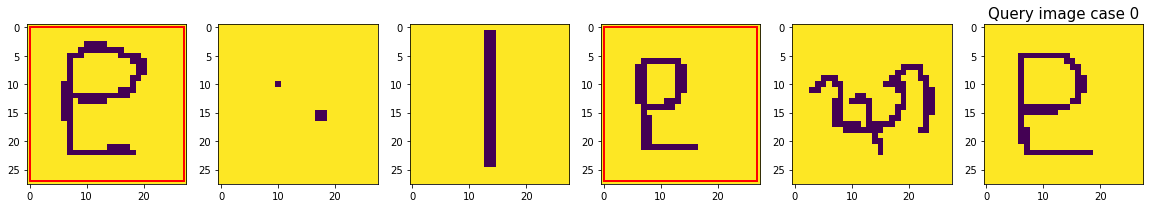

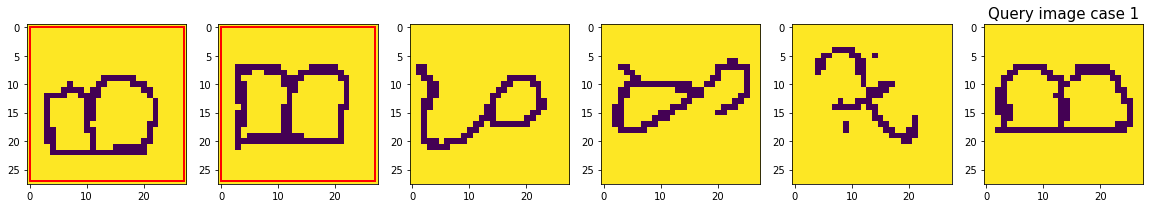

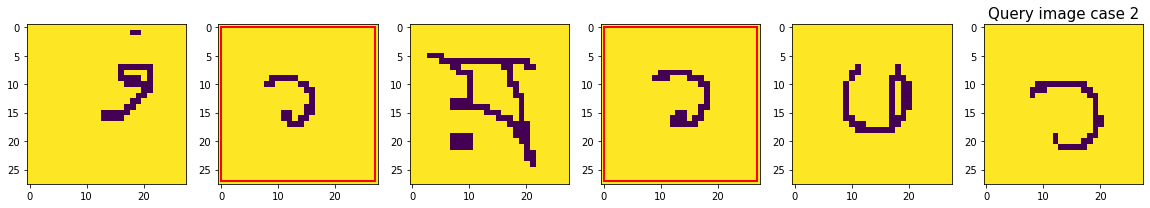

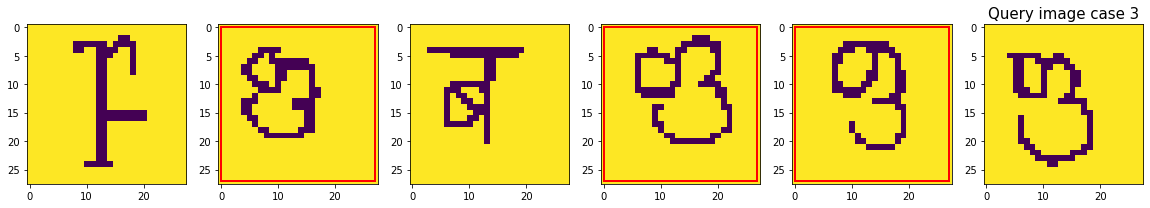

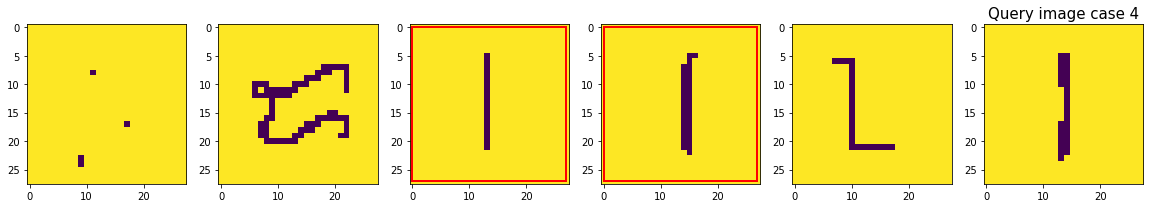

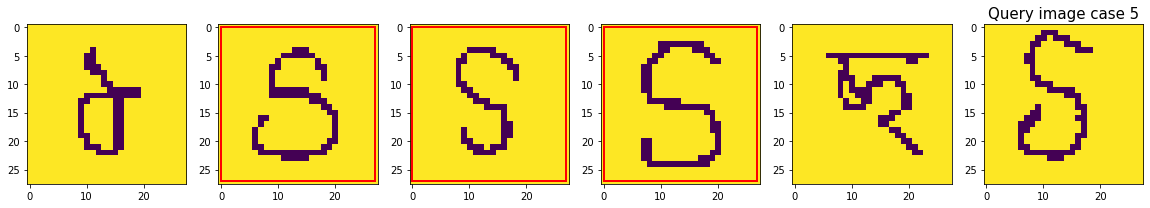

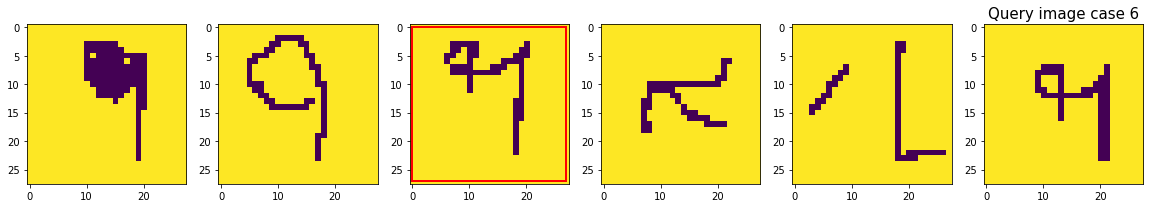

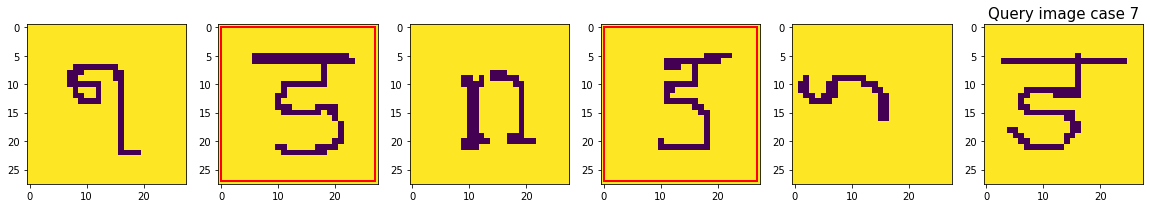

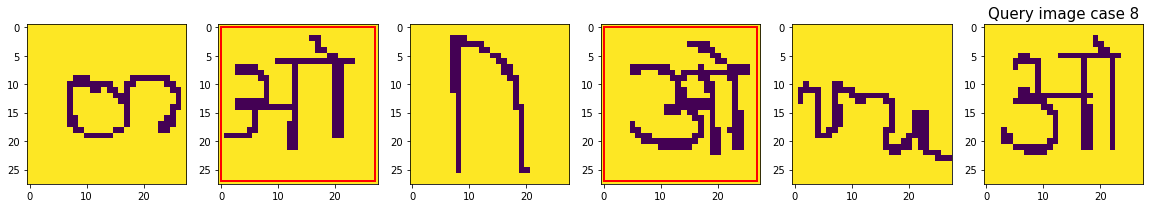

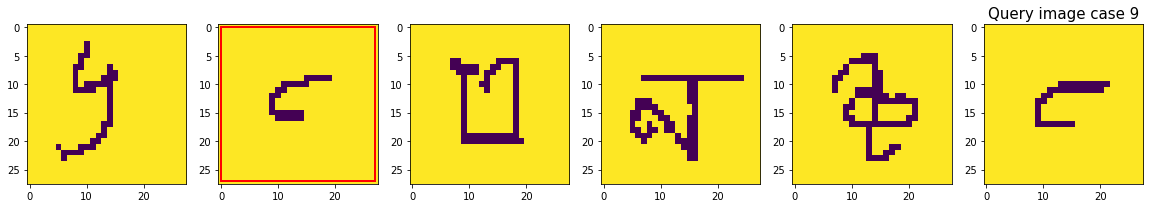

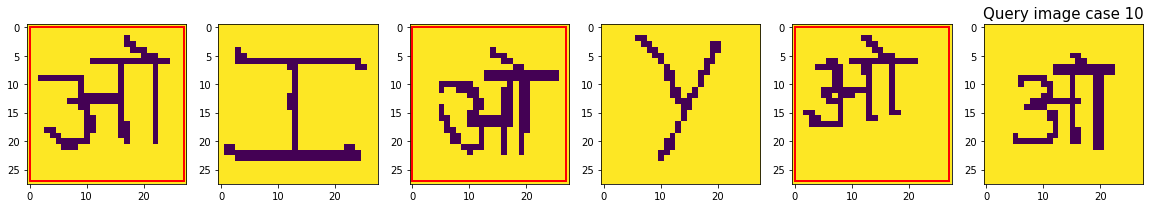

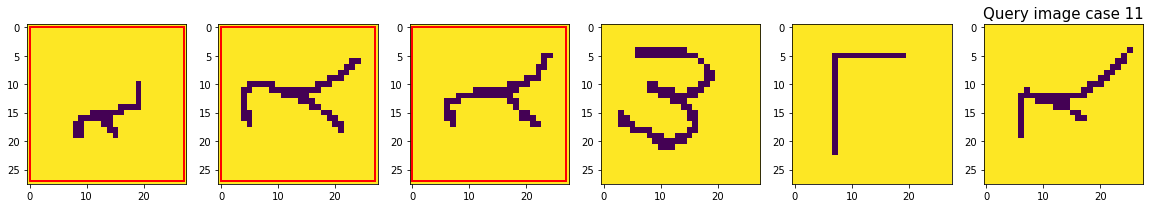

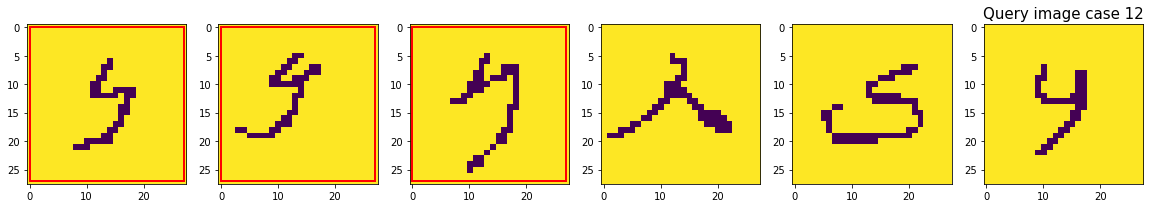

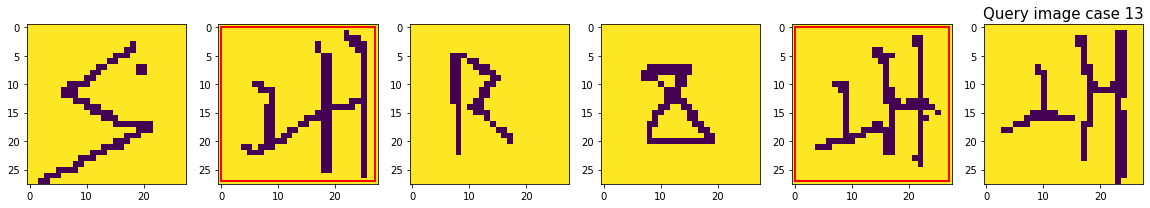

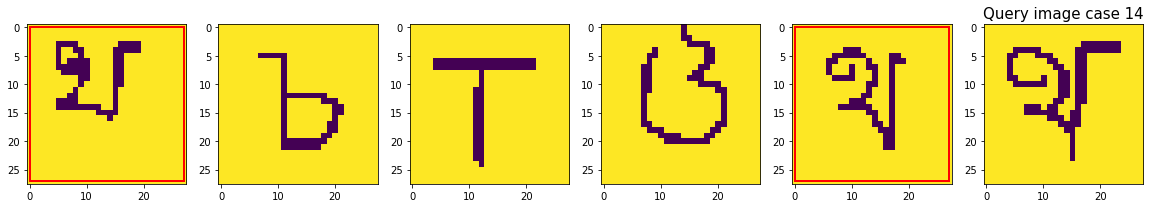

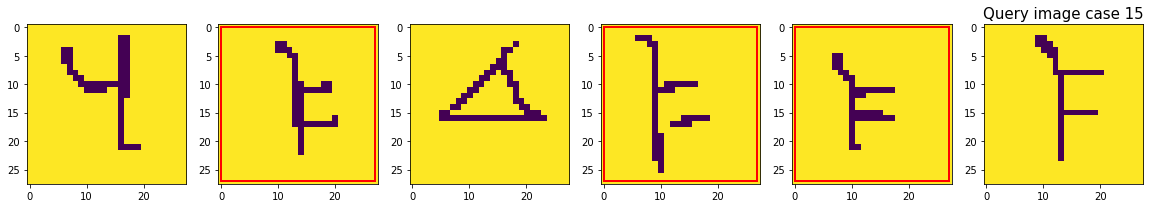

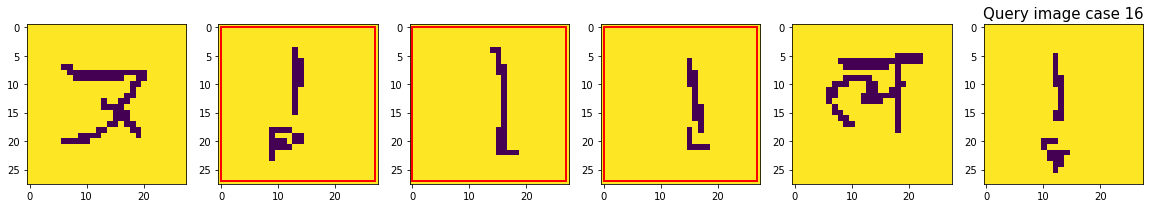

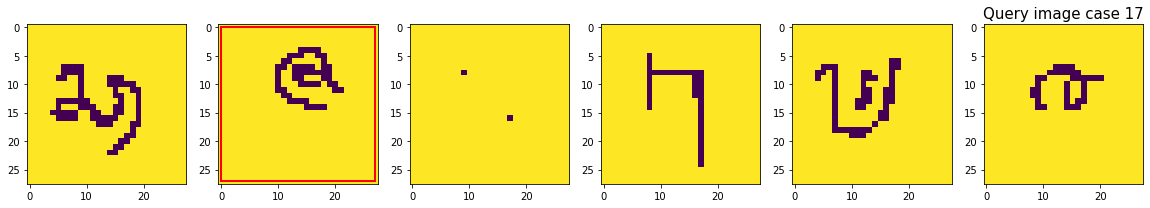

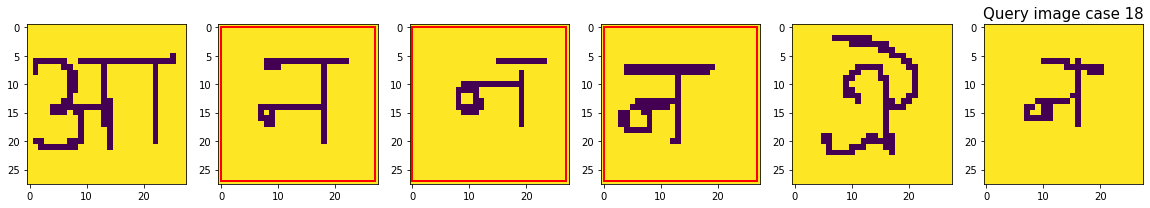

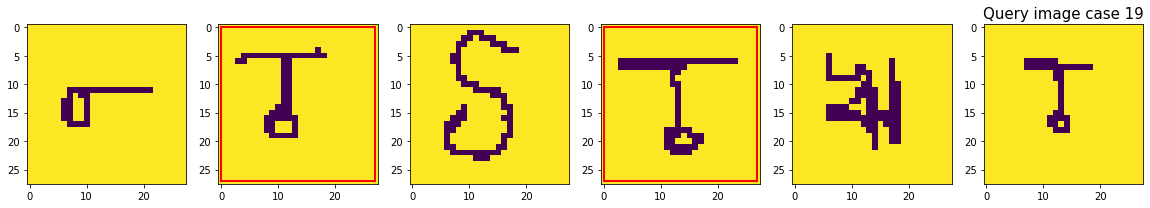

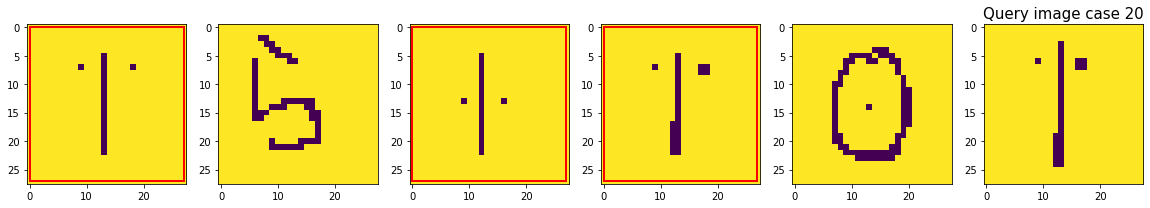

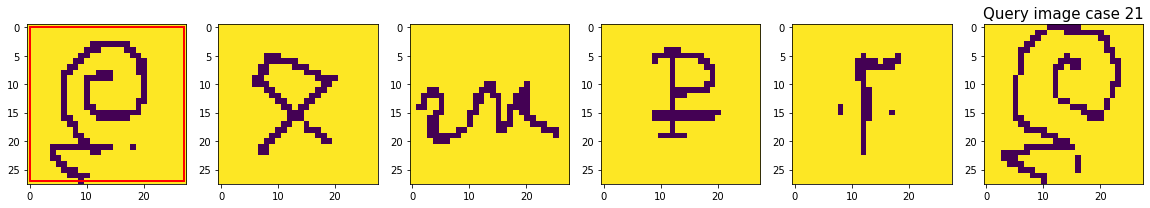

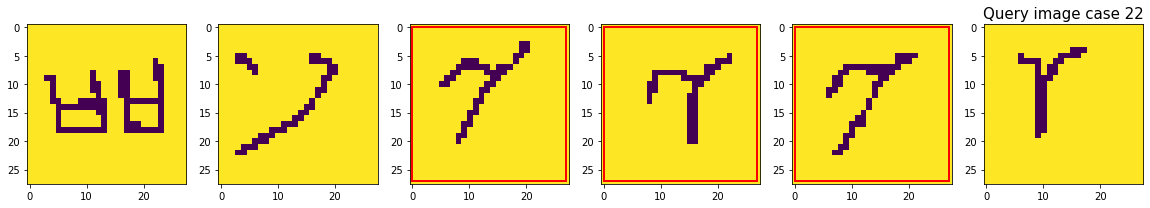

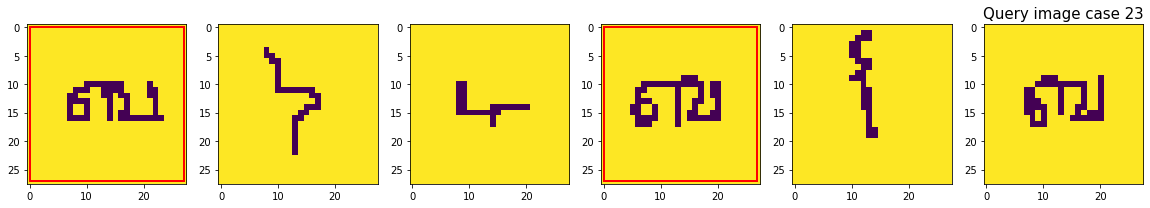

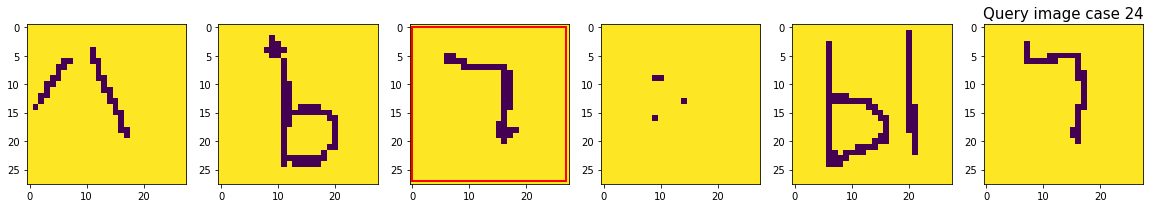

In [128]:
[plot_case(caseID,val_data,val_label) for caseID in range(25)] ;